In [2]:
import numpy as np
import psycopg2
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

dbparams = {
    'dbname': 'bde',
    'port': 5432,
    'host': 'yuma.hpc.nrel.gov',
    'user': 'rlops',
    'password': 'jTeL85L!',
    'options': f'-c search_path=rl',
}

In [3]:
import os
import sys
sys.path.append('..')

from alphazero import config
import stable_rad_config

In [9]:
# Load the game buffer
with psycopg2.connect(**dbparams) as conn:
    df = pd.read_sql_query("select * from {}_game where experiment_id = %s".format(
        config.sql_basename), conn, params=(config.experiment_id,))
    
df.tail(20)

,id,time,experiment_id,gameid,real_reward,final_smiles
1506,1507,2020-10-20 19:20:46.503427,01_noh_with_s,f7f16064,96.174920,[CH2]C(C)=C(CC)C(C)(C)C
1507,1508,2020-10-20 19:20:47.290278,01_noh_with_s,f774a6ff,78.182846,C=C[CH]CCc1cc1=S
1508,1509,2020-10-20 19:20:47.504256,01_noh_with_s,cec7c502,88.816420,C[C](C(C)=O)N(C)C
1509,1510,2020-10-20 19:20:48.416035,01_noh_with_s,a9e28a85,96.174920,[CH2]C(C)=C(CC)C(C)(C)C
1510,1511,2020-10-20 19:20:49.890347,01_noh_with_s,082d653b,92.473430,[CH2]C(C)=C(C)C(C)(C)C
1511,1512,2020-10-20 19:20:50.700923,01_noh_with_s,39a58779,61.634182,CC(=O)C(C)(C)C(=O)[CH]N
1512,1513,2020-10-20 19:20:51.960461,01_noh_with_s,3e10c774,96.174920,[CH2]C(C)=C(CC)C(C)(C)C
1513,1514,2020-10-20 19:20:53.707727,01_noh_with_s,58041387,94.621750,[CH2]C(C)=C(C)C(C)(C)CC
1514,1515,2020-10-20 19:20:56.798837,01_noh_with_s,9374a01d,96.174920,[CH2]C(C)=C(CC)C(C)(C)C
1515,1516,2020-10-20 19:20:57.916954,01_noh_with_s,8875476f,97.312040,CCC1=C(C)[CH]CC1(C)C


In [10]:
# Load the policy training history
log = pd.read_csv(os.path.join(config.checkpoint_filepath, 'log.csv'))
log['time'] = pd.to_datetime(log.time)

Text(0, 0.5, 'Reward')

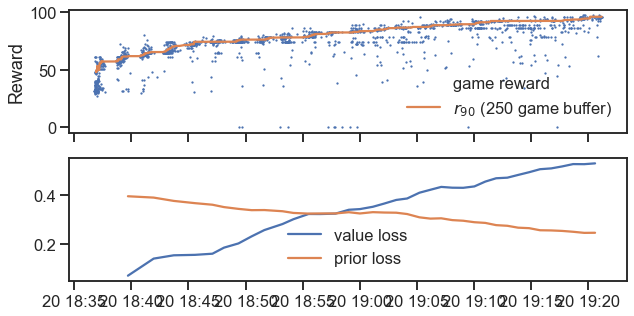

In [11]:
fig, axs = plt.subplots(sharex=True, nrows=2, figsize=(10, 5))

axs[0].plot(df.time, df.real_reward, '.', ms=2.5, label='game reward')
axs[0].plot(df.time, df.real_reward.rolling(250, min_periods=50).quantile(.9), label='$r_{90}$ (250 game buffer)')

axs[1].plot(log.time, log.policy_wrapper_loss, label='value loss')
axs[1].plot(log.time, log.policy_wrapper_1_loss, label='prior loss')

axs[1].legend()
axs[0].legend()

axs[0].set_ylabel('Reward')

In [12]:
# Load the reward buffer to plot the optimal molecules
with psycopg2.connect(**dbparams) as conn:
    rew_df = pd.read_sql_query("select * from {}_reward".format(config.sql_basename), conn)

rew_df.shape

(53777, 7)

In [19]:
rew_df.sort_values('real_reward', ascending=False).head(10)

,smiles,time,real_reward,atom_type,buried_vol,max_spin,atom_index
40156,CCN(CC)C(C)C([O])=O,2020-10-20 19:03:53.758983,100.17078,N,60.576164,0.208108,2
42929,C=C(C)[C](C(C)C)C(C)C,2020-10-20 19:05:55.762249,97.58946,C,69.615685,0.440524,0
49729,CCC1=C(C)[CH]CC1(C)C,2020-10-20 19:12:55.352938,97.31204,C,66.000305,0.373765,3
43105,[CH2]C1=C(C(C)(C)C)CCC1,2020-10-20 19:06:03.457904,96.99348,C,66.330850,0.386747,0
40592,CN(C)[C@@H](CCO)C([O])=O,2020-10-20 19:04:09.144142,96.34715,C,61.314713,0.299351,0
17202,[CH2]C(C)=C(CC)C(C)(C)C,2020-10-20 18:49:30.954298,96.17492,C,68.920784,0.454917,3
45093,C=C(C)C1=C(C)[CH]CCC1,2020-10-20 19:07:49.398799,95.10544,C,61.059807,0.319087,0
31316,CCN(CC)[C@H](C)C([O])=O,2020-10-20 18:59:02.112000,95.07527,N,61.355473,0.325604,4
48728,[CH2]C(C)=C1C(=O)CCC1=O,2020-10-20 19:12:04.232919,95.02231,C,57.608944,0.251733,0
25981,CN(CC([O])=O)C1(C)CC1,2020-10-20 18:55:56.424658,94.79380,N,58.219490,0.268514,1


In [14]:
def is_pareto_efficient(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    orig_costs = np.array(costs)
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return orig_costs[is_efficient_mask]
    else:
        return is_efficient

In [15]:
rew_df.head()

,smiles,time,real_reward,atom_type,buried_vol,max_spin,atom_index
0,C[C](N)N,2020-10-20 18:21:28.899845,42.663445,C,33.435577,0.815443,0
1,[CH2]NOC,2020-10-20 18:21:29.337530,33.144062,C,24.496975,0.827058,3
2,CC1(C)C[N]1,2020-10-20 18:21:30.410984,42.705616,N,35.514618,0.856180,3
3,[CH2]CNN,2020-10-20 18:21:31.394043,33.129753,C,28.828170,0.913968,1
4,[CH]=C(C)O,2020-10-20 18:21:32.083313,37.402225,C,28.733284,0.826621,3


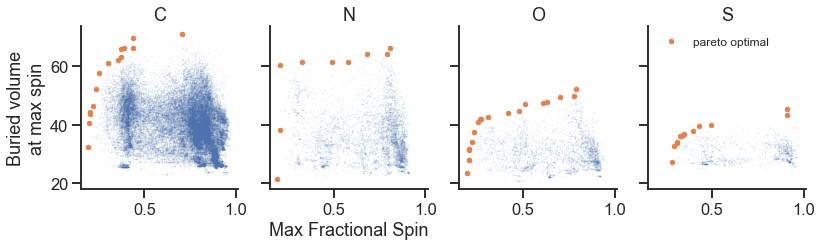

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(13,3), sharex=True, sharey=True)

optimal = []
for ax, atom in zip(axs, ['C', 'N', 'O', 'S']):
    
    vals = rew_df[rew_df.atom_type == atom][['max_spin', 'buried_vol']].dropna()
    vals['buried_vol'] *= -1
    pareto_index = is_pareto_efficient(vals.values, return_mask=False)
    pareto_points = vals.iloc[pareto_index]
    optimal += [vals.iloc[pareto_index].index]
    
    ax.plot(rew_df[rew_df.atom_type == atom]['max_spin'],
            rew_df[rew_df.atom_type == atom]['buried_vol'], '.', ms=1, alpha=.1)
    
    ax.plot(pareto_points['max_spin'], -pareto_points['buried_vol'], '.', label='pareto optimal')
    
    ax.set_title(atom)

    
axs[1].set_xlabel('Max Fractional Spin')
axs[0].set_ylabel('Buried volume\nat max spin')

axs[-1].legend(loc='upper left', fontsize=12)
sns.despine()    

TODO: 
* Maybe do ranked reward on an atom-by-atom basis?
* Also look into sulfur-containing radicals
* Some additional chemical feasibility constraints

In [ ]:
# rew_df.iloc[optimal[0]]